In [1]:
library(pROC)

# Define the directory structure using file.path()
my_dir <- file.path("C:/Users/GPEL_HPENVY/Desktop/Project_Predictive_Analytics_R")

# Check if the directory exists
if (dir.exists(my_dir)) {
  # Set the working directory
  setwd(my_dir)
  cat("Working directory set to:", getwd(), "\n")
} else {
  cat("Directory does not exist:", my_dir, "\n")
}

Warning message:
"package 'pROC' was built under R version 3.6.3"Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var



Working directory set to: C:/Users/GPEL_HPENVY/Desktop/Project_Predictive_Analytics_R 


In [2]:
# set file path
# read csv file
#setwd('H:/GPEL_HPENVY/Documents/UNSW/07_ZZBU6511/Assessment3/')
employees <- read.csv(file = 'employees2.csv')

# Modify the column names to remove unwanted characters (assuming the problematic column is named "ï..Age")
colnames(employees) <- gsub("ï\\.{2}", "", colnames(employees))

In [3]:
# Inspect file
head(employees)


Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobRole,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,HighPerformance
26,No,Travel_Frequently,Research & Development,10,3,3,Male,4,Laboratory Technician,...,1,1,8,3,3,7,7,7,7,0
33,No,Travel_Rarely,Research & Development,13,5,4,Male,3,Healthcare Representative,...,1,0,14,6,3,0,0,0,0,0
59,No,Travel_Rarely,Research & Development,5,3,3,Female,4,Laboratory Technician,...,1,3,12,3,2,1,0,0,0,1
42,No,Travel_Rarely,Research & Development,21,3,2,Male,4,Healthcare Representative,...,3,2,10,2,2,0,0,0,0,0
24,No,Travel_Rarely,Research & Development,27,1,4,Female,2,Manufacturing Director,...,2,2,5,6,3,4,2,3,2,0
29,No,Travel_Rarely,Research & Development,37,2,3,Male,4,Research Scientist,...,3,1,10,3,3,10,7,0,7,1


In [4]:
# Add new binary variables to the employees data frame
employees$Is.Attrition = ifelse(employees$Attrition == "Yes", 1, 0)
employees$Over18 <- NULL  # Don't include Over18 since all response is Yes.

In [5]:
# Split the data to training and testing
set.seed(57)
rows <- sample(nrow(employees), 0.8*nrow(employees))
training <- employees[rows, ]
testing <- employees[-rows, ]

In [6]:
# Making the predictions.  Use all variables except Attrition, Over18 and Is.Attrition
logmod <- glm(
  formula = Is.Attrition ~ . - Attrition - Is.Attrition,
  data = training,
  family = binomial()
)
# Print summary of the prediction
summary(logmod)


Call:
glm(formula = Is.Attrition ~ . - Attrition - Is.Attrition, family = binomial(), 
    data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8655  -0.4531  -0.2191  -0.0721   3.6263  

Coefficients:
                                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      -1.499e+01  8.302e+02  -0.018 0.985596    
Age                              -6.127e-03  1.940e-02  -0.316 0.752115    
BusinessTravelTravel_Frequently   2.270e+00  6.359e-01   3.570 0.000357 ***
BusinessTravelTravel_Rarely       1.303e+00  5.940e-01   2.193 0.028319 *  
DepartmentResearch & Development  1.430e+01  8.302e+02   0.017 0.986254    
DepartmentSales                   1.475e+01  8.302e+02   0.018 0.985825    
DistanceFromHome                  2.756e-02  9.624e-03   2.863 0.004192 ** 
Education                         1.334e-01  1.222e-01   1.092 0.274732    
EnvironmentSatisfaction          -4.411e-01  1.176e-01  -3.752 0.000175 ***
Ge

Setting levels: control = 0, case = 1
Setting direction: controls < cases


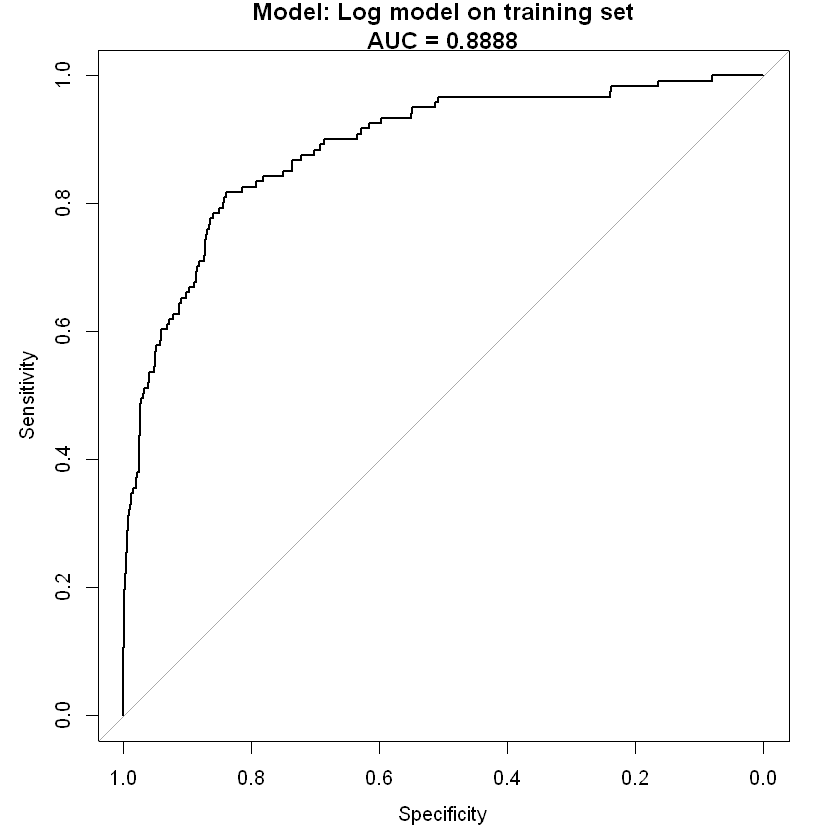

In [7]:
# Do prediction using the training parameters
# Get the probabilities from the model and add them into a new column
training$Probability <- predict(
  object = logmod,
  newdata = training,
  # To get probabilities we set the type to "response"
  type = "response")
# Compute ROC and Printing the area under the ROC curve
training.logroc <- roc(
  formula = training$Is.Attrition ~ training$Probability,
  auc = TRUE)
plot(
  training.logroc,
  main=paste("Model: Log model on training set\nAUC =", round(training.logroc$auc, digits=4))
)

In [8]:
# Turn the probabilities into predictions
training$Prediction = ifelse(training$Probability >= 0.15, 1, 0)
# Get the confusion matrix
conf_matrix_train <- table(training$Prediction, training$Is.Attrition)

# Show the confusion matrix
conf_matrix_train

   
      0   1
  0 534  20
  1 145 101

In [9]:
# Calculate and show the accuracy
accuracy <- sum(diag(conf_matrix_train))/sum(conf_matrix_train)
message("Accuracy: ", accuracy)

# Calculate and show the sensitivity
sensitivity <- conf_matrix_train[2,2]/sum(conf_matrix_train[,2])
message("Sensitivity: ", sensitivity)

# Calculate and show the specificity
specificity <- conf_matrix_train[1,1]/sum(conf_matrix_train[,1])
message("Specificity: ", specificity)

Accuracy: 0.79375
Sensitivity: 0.834710743801653
Specificity: 0.786450662739323


In [10]:
# Testing the model - using the testing dataset and using the Prediction models
testing$ProbabilityTest <- predict(logmod, newdata = testing, type = "response")
testing$PredictionTest <- ifelse(testing$ProbabilityTest >= 0.15, 1, 0)
conf_matrix_test <- table(testing$PredictionTest, testing$Is.Attrition)
message("Confusion matrix for model 1:")
conf_matrix_test

Confusion matrix for model 1:


   
      0   1
  0 129   8
  1  42  21

In [41]:
# Calculate and show the accuracy
accuracy <- sum(diag(conf_matrix_test))/sum(conf_matrix_test)
message("Accuracy: ", accuracy)

# Calculate and show the sensitivity
sensitivity <- conf_matrix_test[2,2]/sum(conf_matrix_test[,2])
message("Sensitivity: ", sensitivity)
# Calculate and show the specificity
specificity <- conf_matrix_test[1,1]/sum(conf_matrix_test[,1])
message("Specificity: ", specificity)

Accuracy: 0.75
Sensitivity: 0.724137931034483
Specificity: 0.754385964912281


In [12]:
citation("pROC")


If you use pROC in published research, please cite the following paper:

  Xavier Robin, Natacha Turck, Alexandre Hainard, Natalia Tiberti,
  Frédérique Lisacek, Jean-Charles Sanchez and Markus Müller (2011).
  pROC: an open-source package for R and S+ to analyze and compare ROC
  curves. BMC Bioinformatics, 12, p. 77.  DOI: 10.1186/1471-2105-12-77
  <http://www.biomedcentral.com/1471-2105/12/77/>

A BibTeX entry for LaTeX users is

  @Article{,
    title = {pROC: an open-source package for R and S+ to analyze and compare ROC curves},
    author = {Xavier Robin and Natacha Turck and Alexandre Hainard and Natalia Tiberti and Frédérique Lisacek and Jean-Charles Sanchez and Markus Müller},
    year = {2011},
    journal = {BMC Bioinformatics},
    volume = {12},
    pages = {77},
  }
